In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import csr_matrix, lil_matrix, identity
import time

from tqdm import tqdm_notebook

In [2]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)

## Build the map

In [3]:
def is_in_box_house(posx, posy, x, y, scaling=1):
    h_size = 6 * scaling
    return (posx < x < posx + h_size and
            posy < y < posy + h_size)


def is_in_l_house(posx, posy, x, y, scaling=1):
    if (posx < x < posx +  6 * scaling and
        posy < y < posy + 26 * scaling):
        return True

    posx -= 4 * scaling
    posy += 20 * scaling

    return (posx < x < posx + 5 * scaling and # +1??
            posy < y < posy + 6 * scaling)


def is_in_L_house(posx, posy, x, y, scaling=1):
    if (posx < x < posx + 6 * scaling and
        posy < y < posy + 26 * scaling):
        return True

    posx += 4 * scaling

    return (posx < x < posx + 4 * scaling and
            posy < y < posy + 6 * scaling)

box_houses = np.array([
    [23, 37],
    [23, 88],
    [46,  4],
    [46, 55],
    [64, 37],
    [64, 88],
    [87,  4],
    [87, 55],
])

L_houses = np.array([
    [23,  4],
    [23, 55],
    [64,  4],
    [64, 55],
])

l_houses = np.array([
    [46, 17],
    [46, 68],
    [87, 17],
    [87, 68],
])

def is_in_house(x, y, scaling):
#     x, y = x / scaling, y / scaling
    for house in (box_houses * scaling):
        if is_in_box_house(*house, x, y, scaling):
            return True

    for house in (L_houses * scaling):
        if is_in_L_house(*house, x, y, scaling):
            return True

    for house in (l_houses * scaling):
        if is_in_l_house(*house, x, y, scaling):
            return True
    return False

def create_du_map(scale):
    grid_size = 100 * scale
    return np.array([is_in_house(i, j, scale)
                     for i in range(grid_size) for j in range(grid_size)]).reshape((grid_size, grid_size))

### Check the map

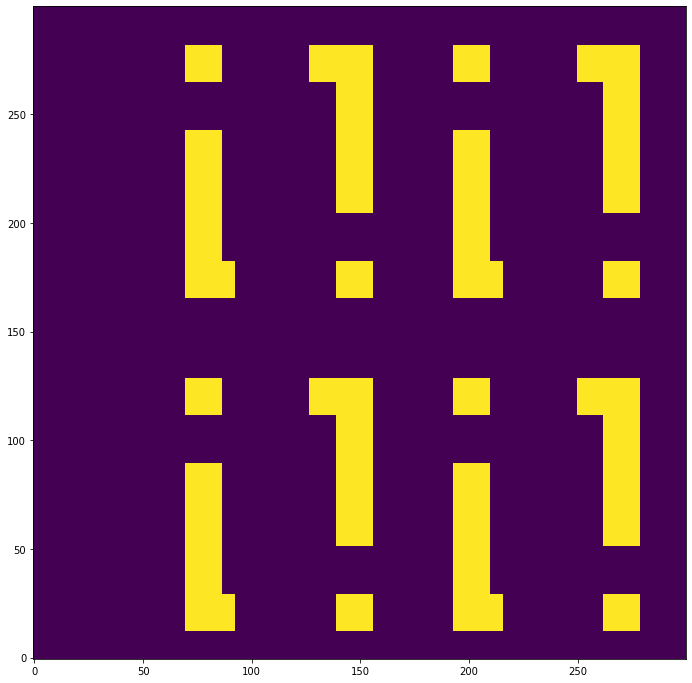

In [4]:
grid_scale = 3
du_map = create_du_map(grid_scale)

plt.imshow(du_map.T)
plt.gca().invert_yaxis()
plt.savefig('scale3.jpg')
plt.show()

## Calculate convection-diffusion equation

In [5]:
def make_trans_matrix():
    pass

def convDiff(k, lambda_x, lambda_y, n_iters, du_map,
             eps=1e-5, tau_coeff=1, save_video=False):
    # Scale the grid size
    grid_size = len(du_map)
    # Set h
    h = 1 / grid_size
    tau = tau_coeff * h ** 2 / (4 * k)
    print(f"Params: grid_size={grid_size}; h={h:.5f}; tau={tau:.5f}")

    N = grid_size * grid_size

    # Init Concentration.
    u = np.zeros((N, 1))
    y0 = np.array(range(grid_size))
    coord_to_u_ind = lambda x, y: x * grid_size + y
    
    # Add Houses as bad values.
    u[du_map.flatten(), 0] = -1
    
    # Init transition matrix.
    A = lil_matrix((N, N))
    
    dx = [1, -1, 0, 0]
    dy = [0, 0, 1, -1]
    common = k / (h ** 2)
    u0coeff = (1 - 4 * tau * common)
    coeffs = [tau * (common - lambda_x / (2 * h)),
              tau * (common + lambda_x / (2 * h)),
              tau * (common - lambda_y / (2 * h)),
              tau * (common + lambda_y / (2 * h))]
    
    for x in range(0, grid_size, 1):
        for y in range(0, grid_size, 1):
            ind = coord_to_u_ind(x, y)
            # u(0, y) = 1 && du_{in_house} = 0
            if x == 0 or du_map[x, y]:
                A[ind, ind] = 1
                continue
            A[ind, ind] = u0coeff
            for x_off, y_off, coeff in zip(dx, dy, coeffs):
                x_neig, y_neig = x + x_off, y + y_off
                
                if (
                    (x_neig >= grid_size) or # (du/dx)_{x=300} = 0
                    (y_neig >= grid_size) or # (du/dy)_{y=300} = 0
                    (y_neig <= 0) or         # (du/dy)_{y=0} = 0
                    du_map[x_neig, y_neig]   # bounce of a house
                   ):
                    A[ind, ind] += coeff
                else:
                    A[ind, coord_to_u_ind(x_neig, y_neig)] = coeff
    
    A = csr_matrix(A)
    
    # Calculate results.
    u[y0, 0] = 1 # Init u(0, y) = 1
    ims = []
    for i in tqdm_notebook(range(n_iters), total=n_iters):
        u_new = A * u
        if save_video and i % 200 == 0:
            im = plt.imshow(u_new.reshape((grid_size, grid_size)).T, animated=True, cmap=current_cmap)
            plt.clim(0, 1)
            plt.gca().invert_yaxis()
            ims.append([im])
        error = np.max(np.abs(u_new - u))
        if error < eps:
            print("Change is less than epsilon. Terminating at step:", i)
            break
        u = u_new
    
    return u.reshape((grid_size, grid_size)), ims

In [6]:
# Create a cmap, which will display out of bound values (our houses) with different color.
current_cmap = matplotlib.cm.get_cmap() # 'tab20c'
current_cmap.set_bad(color='red')
current_cmap.set_under('white')

Params: grid_size=300; h=0.00333; tau=0.00001


Change is less than epsilon. Terminating at step: 36031
Total time: 45.55074
Saved result in "out_test.mp4"


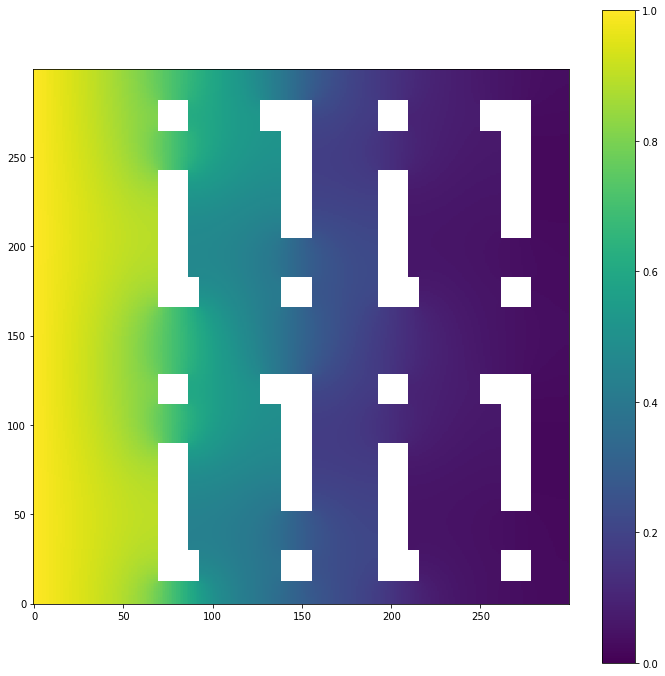

In [7]:
# Given parameters
k = 0.5
lambda_x = 1
lambda_y = 0
# Changeable parameters
grid_scale = 3  # default grid is 100, better to scale by order of 3
n_iters = int(1e4 * 5)
eps = 10e-6
tau_coeff = 1
save_video =True
video_path = 'out_test.mp4' # If you get error about ffmpeg, change to `.gif` (may help)

# Create figure in order to be able to save a video.
fig = plt.figure()

start = time.time()
# Create du map. (True in places where du/dt = 0)
du_map = create_du_map(grid_scale)

# Solve.
u_res, ims = convDiff(k, lambda_x, lambda_y, n_iters,
                du_map, eps, tau_coeff=tau_coeff,
                save_video=save_video)
end = time.time()
print(f'Total time: {end - start:.5f}')

# Save video.
if save_video:
    plt.colorbar()
    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
    ani.save(video_path)
    print(f'Saved result in "{video_path}"')

# Plot.
plt.imshow(u_res.T, cmap=current_cmap)
plt.gca().invert_yaxis()
# plt.colorbar()
plt.clim(0, 1)
plt.show()

## Output

In [10]:
res_path = 'res.txt'
grid_size = len(du_map)

### Output as stated in the task

In [11]:
with open(res_path, 'w') as out_file:
    out_file.write(str(grid_size) + '\n')
    for x in range(0, grid_size, 1):
        out_file.write(' '.join(map(lambda y: ' '.join(map(str, (x, y, u_res[x, y]))), range(0, grid_size, 1))) + '\n')

# print(grid_size)
# for x in range(0, grid_size, 1):
#     print(' '.join(map(lambda y: ' '.join(map(str, (x, y, u_res[x, y]))), range(0, grid_size, 1))))

### Output as stated by Ivan G

In [12]:
with open(res_path, 'w') as out_file:
    out_file.write(str(grid_size) + '\n')
    for x in range(0, grid_size, 1):
        out_file.write(' '.join(map(lambda y: str(u_res[x, y]), range(0, grid_size, 1))) + '\n')

# print(grid_size)
# for x in range(0, grid_size, 1):
#     print(' '.join(map(lambda y: str(u_res[x, y]), range(0, grid_size, 1))))